# Activity Recognition Using Wearable Physiological Measurements: Selection of Features from a Comprehensive Literature Study

This study had the goal of being able to detect different forms of activity by monitoring different metrics of the human body, such as heart activity, lung activity and physical movement of the arm and hand.

The 4 types of activity present in the study are:
    
    1. Neutral;
    2. Emotional;
    3. Mental;
    4. Physical.

The way to induce such activities are as follows:

    - Neutral: by having the subjects watch documentaries;
    - Emotional: by having the subjects watch movies;
    - Mental: by having the subjects play games of mental arithmetics and tetris;
    - Physical: by having the subjects go up and down flights of stairs.

In [1]:
import pandas as pd
from sklearn.datasets import make_regression
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from genetic_selection import GeneticSelectionCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns;
import warnings
warnings.filterwarnings('once')

## Loading the data

The data provided from the "Activity recognition using wearable physiological measurements" dataset consists in 4480 instances of 533 features each.

The first column correspond to the index of the subject. The next 174 attributes are statistics extracted from the ECG signal. The next 151 attributes are features extracted from the TEB signal. The next 104 attributes come from the EDA measured in the arm, and the next 104 ones from the EDA in the hand. The last attribute is the pattern class, that is, the corresponding activity: 1-neutral, 2-emotional, 3-mental and 4-physical.

In [2]:
with open("data/labels.txt","r",encoding="utf-8") as f:
    labels = f.read().split("\n")
    #print(labels)
#labelset=set(labels)
for n in range(len(labels)):
    if 263<=n<=276:
        labels[n] = labels[n] + "_2"
    if 326<=n<=429:
        labels[n]="Arm_" + labels[n]
    if 430<=n<=533:
        labels[n]="Hand_" + labels[n] 
    if n == len(labels)-1:
        labels[n]="Activity"
n=0
"""
for i in labels:
    print(n,i, labels.count(i))
    n+=1
"""

'\nfor i in labels:\n    print(n,i, labels.count(i))\n    n+=1\n'

In [3]:
df=pd.read_csv("data/data.txt",sep=",",names=labels)

In [4]:
df

,Subject index (1_40),ECG_original_mean,ECG_original_std,ECG_original_trimmean25,ECG_original_median,ECG_original_skewness,ECG_original_kurtosis,ECG_original_max,ECG_original_min,ECG_original_prctile25,...,Hand_EDA_Functionals_power_Filt2kurtosis,Hand_EDA_Functionals_power_Filt2max,Hand_EDA_Functionals_power_Filt2min,Hand_EDA_Functionals_power_Filt2prctile25,Hand_EDA_Functionals_power_Filt2prctile75,Hand_EDA_Functionals_power_Filt2geomean(abs),Hand_EDA_Functionals_power_Filt2harmmean,Hand_EDA_Functionals_power_Filt2mad,Hand_EDA_Functionals_power_Filt2baseline,Activity
0,1,-0.004125,0.254095,0.001426,-0.01037,-0.538509,5.95534,1.04063,-1.37437,-0.10937,...,1015.36,7.170320e+08,0.027384,2.53425,17.3882,8.05589,1.80247,1413310.0,3028080.0,1
1,1,0.031029,0.193761,0.012918,-0.00237,0.781415,5.18794,0.98963,-0.71937,-0.08737,...,1015.78,7.058540e+08,0.016947,2.51513,16.5914,7.81769,1.52349,1390180.0,3016420.0,1
2,1,0.015678,0.182336,-0.003028,-0.02337,0.881194,5.66530,0.87563,-0.71937,-0.08037,...,1016.16,6.270180e+08,0.008129,2.25959,15.2312,7.11684,1.25860,1234110.0,3004430.0,1
3,1,0.014525,0.176636,-0.006161,-0.02737,1.024900,6.10968,0.91063,-0.71937,-0.08037,...,1015.61,5.597480e+08,0.007377,2.13924,14.4663,6.70236,1.26643,1102720.0,2992170.0,1
4,1,0.010349,0.179248,-0.008526,-0.02737,0.935697,5.83902,0.91063,-0.75637,-0.08337,...,1015.67,4.844730e+08,0.011448,1.93595,12.5493,6.08647,1.22387,954322.0,2979610.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4475,40,-0.015981,0.254373,-0.013341,-0.00101,-0.165105,5.15843,1.03999,-1.19301,-0.15801,...,1014.61,3.237410e+09,0.132094,9.48535,73.9901,31.82590,5.16972,6390410.0,398810.0,4
4476,40,-0.008857,0.238946,-0.010767,-0.00901,-0.034522,5.43013,1.01499,-1.10201,-0.14501,...,1016.07,3.156070e+09,0.133406,8.73701,68.4041,29.83820,5.06743,6214830.0,412407.0,4
4477,40,0.024672,0.213325,0.014418,0.01099,0.613841,4.55481,1.01499,-0.57301,-0.10401,...,1016.06,3.052520e+09,0.138525,8.90410,68.5051,30.45150,5.88492,6011070.0,425422.0,4
4478,40,0.025063,0.212210,0.015656,0.01299,0.593249,4.58374,0.95799,-0.64101,-0.10001,...,1015.80,3.322710e+09,0.076570,8.97766,72.4431,30.38700,4.43563,6544010.0,439695.0,4


In [5]:
df.isnull().sum()

Subject index (1_40)                            0
ECG_original_mean                               0
ECG_original_std                                0
ECG_original_trimmean25                         0
ECG_original_median                             0
                                               ..
Hand_EDA_Functionals_power_Filt2geomean(abs)    0
Hand_EDA_Functionals_power_Filt2harmmean        0
Hand_EDA_Functionals_power_Filt2mad             0
Hand_EDA_Functionals_power_Filt2baseline        0
Activity                                        0
Length: 535, dtype: int64

In [6]:
df.groupby('Activity').mean()

,Subject index (1_40),ECG_original_mean,ECG_original_std,ECG_original_trimmean25,ECG_original_median,ECG_original_skewness,ECG_original_kurtosis,ECG_original_max,ECG_original_min,ECG_original_prctile25,...,Hand_EDA_Functionals_power_Filt2skewness,Hand_EDA_Functionals_power_Filt2kurtosis,Hand_EDA_Functionals_power_Filt2max,Hand_EDA_Functionals_power_Filt2min,Hand_EDA_Functionals_power_Filt2prctile25,Hand_EDA_Functionals_power_Filt2prctile75,Hand_EDA_Functionals_power_Filt2geomean(abs),Hand_EDA_Functionals_power_Filt2harmmean,Hand_EDA_Functionals_power_Filt2mad,Hand_EDA_Functionals_power_Filt2baseline
Activity,,,,,,,,,,,,,,,,,,,,,
1,20.5,-0.017248,0.224012,-0.035954,-0.056528,0.937650,8.602679,0.958904,-0.723009,-0.147302,...,31.076512,999.006146,9.787362e+09,0.086875,26.094028,209.055769,79.662689,5.520061,1.927879e+07,1.358014e+07
2,20.5,-0.015742,0.293427,-0.030485,-0.054670,0.935858,8.273527,1.049734,-0.849642,-0.198350,...,30.909530,991.348837,1.181007e+10,0.096258,31.243043,251.225875,95.839197,6.893809,2.326209e+07,1.275656e+07
3,20.5,-0.017345,0.286182,-0.033134,-0.057011,0.840043,7.112982,1.019942,-0.845316,-0.209066,...,30.818430,987.180680,1.783115e+10,0.106472,46.549498,376.558618,142.193595,8.290682,3.512487e+07,1.302790e+07
4,20.5,0.326771,1.151261,0.357649,0.443789,-0.149969,3.957743,2.987728,-2.554684,-0.486353,...,31.161746,1002.965500,3.190325e+10,0.297815,83.263698,675.167256,259.468831,16.685674,6.286903e+07,1.502544e+07


In [7]:
futures =['Subject index (1_40)',
        'ECG_hrv_geomean(abs)','ECG_RR_window_mean','ECG_Logstd','ECG_A1_DFA','ECG_HR_min_div_mean',
        'ECG_hrv_mean', 'ECG_amplitude_RR_mean','ECG_original_skewness','ECG_amplitude_RR_mad','ECG_amplitude_RR_std',
        'ECG_RR_window_trimmean25','ECG_RR_window_median','ECG_RR_window_geomean(abs)','IT_RF_mean','IT_BRV_mean',
        'IT_BRV_min','IT_PSD_mean','IT_VLF_mean','IT_MF_mean','IT_LF_mean',
        'IT_HF_LF','IT_BRV_mean','IT_LF_MF_HF','IT_Original_mean','IT_MF_HF',
        'IT_RF_mean','IT_LF_prctile75','IT_Original_prctile75','Hand_EDA_Original_mean','Hand_EDA_processed_mean',
        'Hand_EDA_Functionals_power_Fil12mean','Hand_EDA_amp_scr','Hand_EDA_Functionals_power_Filt2mean','Arm_EDA_processed_skewness','Hand_EDA_n_ocu',
        'Hand_EDA_cross_neg','Hand_EDA_cross_pos','Hand_EDA_processed_max','Hand_EDA_processed_min','Hand_EDA_processed_median',
        'Activity']
df2=df[futures]


In [8]:
df2

,Subject index (1_40),ECG_hrv_geomean(abs),ECG_RR_window_mean,ECG_Logstd,ECG_A1_DFA,ECG_HR_min_div_mean,ECG_hrv_mean,ECG_amplitude_RR_mean,ECG_original_skewness,ECG_amplitude_RR_mad,...,Hand_EDA_amp_scr,Hand_EDA_Functionals_power_Filt2mean,Arm_EDA_processed_skewness,Hand_EDA_n_ocu,Hand_EDA_cross_neg,Hand_EDA_cross_pos,Hand_EDA_processed_max,Hand_EDA_processed_min,Hand_EDA_processed_median,Activity
0,1,9.36956,231.8140,2.78953,0.839929,65.0137,-10.47320,0.715107,-0.538509,0.117890,...,798.6800,708396.0,0.077519,16,16,16,137.1620,-49.9609,-6.10858,1
1,1,4.11429,230.5000,2.74429,0.421384,65.3604,-5.46333,0.752583,0.781415,0.069204,...,798.6800,696749.0,-0.156846,20,21,20,112.9340,-39.4358,-7.62735,1
2,1,7.89762,240.7070,3.03596,0.541015,62.7543,-8.67295,0.727153,0.881194,0.055406,...,798.6800,618563.0,-0.163878,23,23,24,45.5984,-33.1896,-6.62220,1
3,1,5.41358,247.3080,3.10133,0.649132,61.1303,-9.31017,0.732130,1.024900,0.061750,...,798.6800,552676.0,-0.305743,28,28,28,45.0498,-33.1896,-6.46312,1
4,1,12.69910,247.7440,3.00381,0.961549,60.9227,-13.37080,0.722305,0.935697,0.060459,...,798.6800,478306.0,-0.245040,32,32,32,45.0498,-33.1896,-6.89667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4475,40,84.72960,87.0351,2.51455,0.557953,174.3390,86.03050,0.577782,-0.165105,0.152142,...,33.3008,3205320.0,0.151985,23,23,24,566.6350,-534.0270,13.91230,4
4476,40,69.28640,86.9386,2.72296,0.614966,175.3840,79.86970,0.579199,-0.034522,0.142474,...,33.3008,3118180.0,0.131757,25,25,24,566.6350,-534.0270,5.98424,4
4477,40,66.93240,88.8304,2.94572,0.430609,173.1520,74.36520,0.611636,0.613841,0.122476,...,33.3008,3015340.0,0.043957,24,24,24,566.6350,-534.0270,6.51911,4
4478,40,71.95700,89.0991,2.88725,0.541363,172.0850,75.22100,0.611437,0.593249,0.124635,...,33.3008,3280050.0,-0.017275,30,30,29,334.1730,-100.7390,7.34174,4


In [9]:
X = df2.drop("Activity", axis=1)
y = df2["Activity"]

print("X.shape = " + str(X.shape))
print("y.shape = " + str(y.shape))

X.shape = (4480, 41)
y.shape = (4480,)


In [10]:
from sklearn.model_selection import train_test_split
#a=np.linspace(1120,4479, num=3360)
#X=X.drop(a)
#y=y.drop(a)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

## Function Definition

In [11]:
def print_accuracy_table(accuracies,labels):
    print("Accuracy of the classifiers/n")
    data = {"VSM_linear":[accuracies[0]],"VSM_rbf":[accuracies[1]],"mlp":[accuracies[2]],"knn":[accuracies[3]],"rf":[accuracies[4]]}
    df1=pd.DataFrame(data, columns=labels)
    df1.style
    print(df1)

In [12]:
def get_confusion_matrix(y_pred):
    mat = confusion_matrix(y_test, y_pred)
    print("CONFUSION MATRIX")
    hm=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=['Neutral','Emotional','Mental','Physical'],
                yticklabels=['Neutral','Emotional','Mental','Physical'])
    plt.xlabel('true label')
    plt.ylabel('predicted label');

In [13]:
def get_classification_report(y_pred):
    print("CLASSIFICATION REPORT")
    print(classification_report(y_test, y_pred,
                            target_names=['Neutral','Emotional','Mental','Physical']))

## Feature Selection

Separate each measurement data in their category

In [14]:
df_ECG = df[[col for col in df if col.startswith('ECG')]]#X.iloc[:, 1:175]
df_TEB = df[[col for col in df if col.startswith('IT')]]#X.iloc[:, 176:326]
df_EDA_arm = df[[col for col in df if col.startswith('Arm')]]#X.iloc[:, 327:430]
df_EDA_hand = df[[col for col in df if col.startswith('Hand')]]#X.iloc[:, 431:534]
Feature_Set = {"ECG":df_ECG,"TEB":df_TEB,"ARM":df_EDA_arm,"HAND":df_EDA_hand}



In [ ]:
# For this work, the number of features selected was discretized by group size in 5, 10, 20, 40, 60, 80 and the full set
#N_max = [5, 10, 20, 40, 60, 80]
#N_max.append(X_ECG.shape[1])
N_max = [5, 10, 20] #######removed 40 just for faster testing
report = {}
# Each combination is ranked using the mean squared error of a LSLC measured using the design set.
for f_set in Feature_Set:
    estimator = LogisticRegression(solver = "liblinear", C = 6, tol = 1, fit_intercept = True)
    report[f_set]={}
    #report = pd.DataFrame()
    nofeats = [] 
    chosen_feats = [] 
    cvscore = [] 


    # for each of the N_max we'll select the best features usig a Genetic Algorithm
    for k in N_max:

        print("\nFinding features whith a N_max = " + str(k) + " for set of features " + f_set +"...")

        selector = GeneticSelectionCV(estimator,
                                    cv = 40,
                                    verbose = 0,
                                    scoring = "accuracy",
                                    max_features = k,
                                    n_population = 100,
                                    crossover_proba = 0.5,
                                    mutation_proba = 0.2,
                                    n_generations = 10,
                                    crossover_independent_proba=0.5,
                                    mutation_independent_proba=0.01,
                                    tournament_size = 3,
                                    n_gen_no_change=10,
                                    caching=True,
                                    n_jobs=-1)

        
        selector = selector.fit(Feature_Set[f_set], y)

        genfeats = Feature_Set[f_set].columns[selector.support_]
        genfeats = list(genfeats)
        print("Chosen Feats:  ", genfeats)
        

        cv_score = selector.generation_scores_[-1]
        nofeats.append(len(genfeats)) 
        chosen_feats.append(genfeats) 
        cvscore.append(cv_score)
    #########saving to dict to access later    
    report[f_set][k]={}
    report[f_set][k]["No of Feats"] = nofeats
    report[f_set][k]["Chosen Feats"] = chosen_feats
    report[f_set][k]["Scores"] = cvscore

    print(report[f_set][k])


Finding features whith a N_max = 5 for set of features ECG...
Chosen Feats:   ['ECG_HR_min_div_geomean(abs)', 'ECG_DBD', 'ECG_M', 'ECG_hrv_prctile25']

Finding features whith a N_max = 10 for set of features ECG...
Chosen Feats:   ['ECG_RR_window_std', 'ECG_HR_min_div_min', 'ECG_hrv_mean', 'ECG_hrv_trimmean25', 'ECG_hrv_median', 'ECG_hrv_max', 'ECG_PSD_prctile25', 'ECG_p_LF_geomean(abs)', 'ECG_p_LF_baseline']

Finding features whith a N_max = 20 for set of features ECG...
Chosen Feats:   ['ECG_original_skewness', 'ECG_original_geomean(abs)', 'ECG_RR_window_mad', 'ECG_amplitude_RR_mad', 'ECG_HR_min_div_trimmean25', 'ECG_hrv_mean', 'ECG_hrv_trimmean25', 'ECG_hrv_prctile75', 'ECG_hrv_geomean(abs)', 'ECG_p_VFL_mad', 'ECG_p_VFL_baseline', 'ECG_p_LF_median', 'ECG_p_HF_mad']
{'No of Feats': [4, 9, 13], 'Chosen Feats': [['ECG_HR_min_div_geomean(abs)', 'ECG_DBD', 'ECG_M', 'ECG_hrv_prctile25'], ['ECG_RR_window_std', 'ECG_HR_min_div_min', 'ECG_hrv_mean', 'ECG_hrv_trimmean25', 'ECG_hrv_median', '

## Classification

### Least Squares Linear Classifier (LSLC)

In [16]:
%%time
reg_linear = LinearRegression()

# k is the number of subjects available in the design database: 40 subjects
k = 40

# cross validation
reg_linear_scores = cross_val_score(reg_linear, X_train, y_train, cv=k, scoring='r2')

# outputs the scores
print('Cross Validation scores: {}'.format(reg_linear_scores))
print("\nAverage 40-Fold CV Score: {}".format(np.mean(reg_linear_scores)))
%time

Cross Validation scores: [0.79581321 0.68184088 0.61028907 0.75751828 0.70322845 0.66000133
 0.78036424 0.78003032 0.83177708 0.79925338 0.73878102 0.7366248
 0.68221323 0.71770928 0.73418077 0.77200245 0.80336067 0.72875519
 0.70167874 0.79590839 0.69497919 0.73726182 0.60875504 0.73470075
 0.7017564  0.69181519 0.79799429 0.66962175 0.78658286 0.75941909
 0.70354168 0.72392596 0.68938749 0.61552416 0.77446743 0.73568139
 0.77048819 0.79825183 0.66320469 0.78789916]

Average 40-Fold CV Score: 0.7314147293586883
Wall time: 0 ns
Wall time: 329 ms


### Least Squares Quadratic Classifier (LSQC)

In [17]:
%%time
poly = PolynomialFeatures(degree=2)

X_poli = poly.fit_transform(X_train)
y_poli = poly.fit_transform(y_train.values.reshape(-1, 1))

reg_quadratic = make_pipeline(PolynomialFeatures(2), LinearRegression())


# cross validation
#reg_quadratic_scores = cross_val_score(reg_quadratic, X_poli, y_poli, cv=k, scoring='r2')

# outputs the scores
print('Cross Validation scores: {}'.format(reg_quadratic_scores))
print("\nAverage 40-Fold CV Score: {}".format(np.mean(reg_quadratic_scores)))
%time

NameError: name 'reg_quadratic_scores' is not defined

### Support Vector Machines Linear (SVMs_lin)

In [18]:
%%time
vsmc_linear = SVC(kernel='linear', random_state=0, probability=True,max_iter=100000) #Support Vector Machine Linear
vsmc_linear.fit(X_train,y_train)
y_pred_svm_linear=vsmc_linear.predict(X_test)
accuracy_svm_linear="{:.2%}".format(metrics.accuracy_score(y_test, y_pred_svm_linear))
%time

Wall time: 0 ns
Wall time: 15.4 s


C:\Users\rodri\anaconda3\lib\site-packages\sklearn\svm\_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


CONFUSION MATRIX
CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.27      0.90      0.41       325
   Emotional       0.15      0.09      0.11       336
      Mental       0.25      0.00      0.01       341
    Physical       0.22      0.02      0.04       342

    accuracy                           0.25      1344
   macro avg       0.22      0.26      0.14      1344
weighted avg       0.22      0.25      0.14      1344



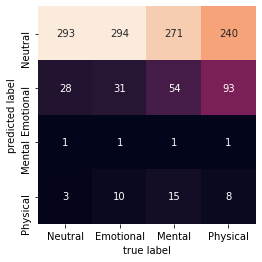

In [19]:
get_confusion_matrix(y_pred_svm_linear);
get_classification_report(y_pred_svm_linear);

### Support Vector Machines (SVMs_rbf)

In [20]:
%%time
vsmc_rbf = SVC(kernel='rbf', random_state=0, probability=True,max_iter=100000) #Support Vector Machine Gaussian Kernel
vsmc_rbf.fit(X_train,y_train)
y_pred_svm_rbf=vsmc_rbf.predict(X_test)
accuracy_svm_rbf="{:.2%}".format(metrics.accuracy_score(y_test, y_pred_svm_rbf))
%time

Wall time: 0 ns
Wall time: 2.98 s


CONFUSION MATRIX
CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.30      0.84      0.44       325
   Emotional       0.50      0.01      0.01       336
      Mental       0.42      0.09      0.14       341
    Physical       0.47      0.50      0.48       342

    accuracy                           0.35      1344
   macro avg       0.42      0.36      0.27      1344
weighted avg       0.42      0.35      0.27      1344



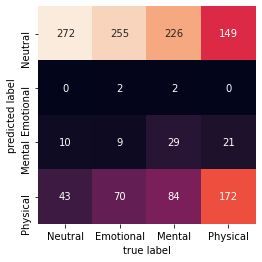

In [21]:
get_confusion_matrix(y_pred_svm_rbf);
get_classification_report(y_pred_svm_rbf);

### Multi-layer Perceptrons (MLPs)

In [22]:
%%time
mlpc=MLPClassifier(random_state=1, max_iter=100000) #multilayer perceptron classifier
mlpc.fit(X_train,y_train)
y_pred_mlp=mlpc.predict(X_test)
accuracy_mlp="{:.2%}".format(metrics.accuracy_score(y_test, y_pred_mlp))
%time

Wall time: 0 ns
Wall time: 318 ms


CONFUSION MATRIX
CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       1.00      0.13      0.23       325
   Emotional       0.46      0.23      0.31       336
      Mental       0.25      0.01      0.01       341
    Physical       0.30      0.98      0.46       342

    accuracy                           0.34      1344
   macro avg       0.50      0.34      0.25      1344
weighted avg       0.50      0.34      0.25      1344



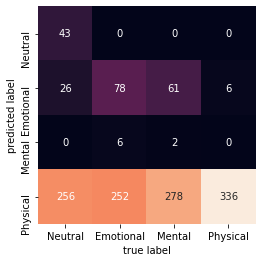

In [23]:
get_confusion_matrix(y_pred_mlp);
get_classification_report(y_pred_mlp);

### k-Nearest Neighbor (kNN)

#### Computation of the best key value

Text(0, 0.5, 'Mean Error')

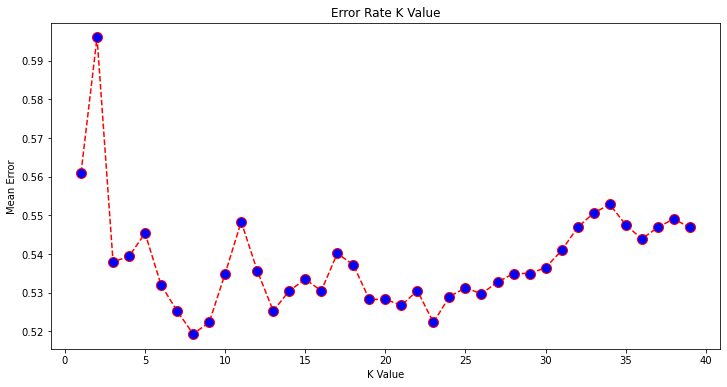

In [24]:
# Find k best value from knn
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))
    
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In [25]:
%%time
knnc=KNeighborsClassifier(n_neighbors=2) # k value suggested in the pdf
knnc.fit(X_train,y_train)
y_pred_knn=knnc.predict(X_test)
accuracy_knn="{:.2%}".format(metrics.accuracy_score(y_test, y_pred_knn))
%time

Wall time: 0 ns
Wall time: 64 ms


CONFUSION MATRIX
CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       0.41      0.64      0.50       325
   Emotional       0.35      0.43      0.39       336
      Mental       0.36      0.28      0.31       341
    Physical       0.59      0.28      0.38       342

    accuracy                           0.40      1344
   macro avg       0.43      0.41      0.40      1344
weighted avg       0.43      0.40      0.39      1344



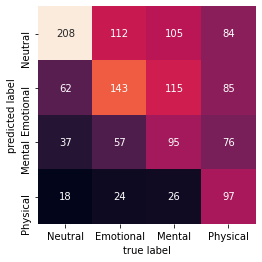

In [26]:
get_confusion_matrix(y_pred_knn);
get_classification_report(y_pred_knn);

### Centroid Displacement-Based k-Nearest Neighbor (CDNN)

### Random Forests (RF)

In [27]:
%%time
rfc=RandomForestClassifier(n_estimators=1000)
rfc.fit(X_train,y_train)
y_pred_rf=rfc.predict(X_test)
accuracy_rf="{:.2%}".format(metrics.accuracy_score(y_test, y_pred_rf))
%time

Wall time: 0 ns
Wall time: 8.28 s


In [28]:
accuracies=[accuracy_svm_linear,accuracy_svm_rbf,accuracy_mlp,accuracy_knn,accuracy_rf]
labels=["VSM_linear","VSM_rbf","mlp","knn","rf"]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Neutral       1.00      0.96      0.98       325
   Emotional       0.94      0.96      0.95       336
      Mental       0.93      0.96      0.95       341
    Physical       1.00      0.99      0.99       342

    accuracy                           0.97      1344
   macro avg       0.97      0.97      0.97      1344
weighted avg       0.97      0.97      0.97      1344

CONFUSION MATRIX


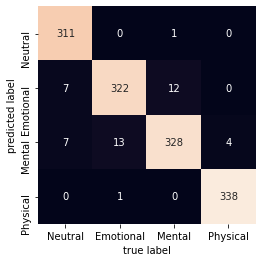

In [29]:
get_classification_report(y_pred_rf);
get_confusion_matrix(y_pred_rf);

In [30]:
print_accuracy_table(accuracies,labels);

Accuracy of the classifiers/n
  VSM_linear VSM_rbf     mlp     knn      rf
0     24.78%  35.34%  34.15%  40.40%  96.65%
